In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import nrrd

In [2]:
# Dataset Directory
PATH = "../dataset"

# Training Dataset Directory
DATA_DIR_TRAIN = "/training_data"


# full path
DATA_DIR_TRAIN = PATH + DATA_DIR_TRAIN


# List of training and validation patient list
train_val_patient_list = os.listdir(DATA_DIR_TRAIN)

#print(train_val_patient_list)

patient_list = sorted([os.path.join(DATA_DIR_TRAIN, pid) for pid in train_val_patient_list])

temp_list = sorted([os.listdir(pid) for pid in patient_list])
print(temp_list[1][0])
print(len(temp_list))
i=0
patient_path = []
for pid in patient_list:
    patient_path.append(pid+"/"+temp_list[i][0])
    i+=1
patient_path.sort()

UT0029_20110520
110


In [3]:
from sklearn.model_selection import train_test_split

# Spliting the training dataset to 80% training and 20% validation data
training_dir, validation_dir = train_test_split(patient_path, test_size=0.2, random_state=20)

print(len(training_dir))
print(len(validation_dir))

88
22


In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    pic_name = ""
    if n==4:
        pic_name = images.pop('pic_name', 'No Key found')
        n = n-1
    fig_image = plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        x = image
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if x.shape[0]==1:
            x = x.transpose(1,2,0)
        plt.imshow(x)
    plt.show()
    if pic_name:
        fig_image.savefig(pic_name+'.png')
    fig_image.savefig('prediction.png')

In [5]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [6]:
class AtriaDataset(Dataset):
    def __init__(self, patient_path, augmentation=None, preprocessing=None):
        
        self.patient_path = patient_path

        self.image_folder_list = [os.path.join(patients, "Images") 
                                  for patients in self.patient_path]
        self.label_folder_list = [os.path.join(patients, "Labels") 
                                  for patients in self.patient_path]
        
        self.mri_image = []
        
        for file_name in self.image_folder_list:
            images = os.listdir(file_name)
            for img in images:
                self.mri_image.append(os.path.join(file_name, img))

        self.mri_image.sort()

        self.mask = []
        
        for file_name in self.label_folder_list:
            labels = os.listdir(file_name)
            for label in labels:
                self.mask.append(os.path.join(file_name, label))

        self.mask.sort()
        
        self.full_list = sorted((self.mri_image[i], self.mask[i]) 
                                for i in range(len(self.mri_image)))
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.data_size = len(self.full_list)
    
    
    def __getitem__(self, index):
        
        image = cv2.imread(self.full_list[index][0],0)
        mask = cv2.imread(self.full_list[index][1],0)
        image = cv2.resize(image, (384,384), interpolation = cv2.INTER_AREA)
        mask = cv2.resize(mask, (384,384), interpolation = cv2.INTER_AREA)
        image = image[:, :, np.newaxis]
        mask = mask[:, :, np.newaxis]
        #print(mask.shape)
        
        mask[mask>0] = 1
        '''thresh, mask = cv2.threshold(mask,128,255,cv2.THRESH_BINARY)
        mask = mask/255
        mask = np.expand_dims(mask, axis=2)'''
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
    
    
    def __len__(self):
        return self.data_size

0 255 (384, 384, 1) <class 'numpy.ndarray'>
0 1 (384, 384, 1) <class 'numpy.ndarray'>


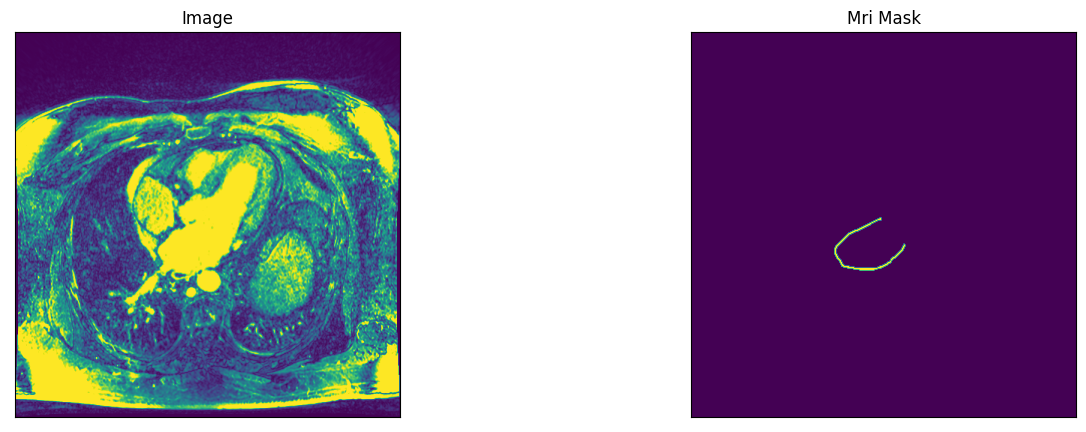

In [7]:
train_dataset = AtriaDataset(training_dir)

image, mask = train_dataset[20]
print(np.min(image), np.max(image), image.shape, type(image))
print(np.min(mask), np.max(mask), mask.shape, type(mask))

visualize(
    image=image, 
    mri_mask=mask,
)

In [8]:
import albumentations as albu

In [9]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.8),
        albu.ShiftScaleRotate(scale_limit=0.5, shift_limit=0.0625, rotate_limit=45, p=0.2),
        albu.RandomBrightnessContrast(p=0.9),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        
        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    #print(type(x))
    return x.transpose(2, 0, 1).astype('float32')

def conv_mask(x, **kwargs):
    thresh, img = cv2.threshold(x,128,255,cv2.THRESH_BINARY)
    img = img/255
    img = np.expand_dims(img, axis=2)
    return img

def std_image(x, **kwargs):
    mean=np.mean(x)
    std=np.std(x)
    eps = 1e-5
    if std == 0:
        std = std+eps
    x = (x - mean)/std
    return x

def norm_image(x, **kwargs):
    x = x/np.max(x)
    return x


def get_preprocessing():
    _transform = [
        albu.Lambda(image=norm_image),
        albu.Lambda(image=to_tensor, mask=to_tensor)
    ]
    return albu.Compose(_transform)

0.0 1.0 (1, 384, 384) <class 'numpy.ndarray'> 0.15359814
0.0 1.0 (1, 384, 384) <class 'numpy.ndarray'> 0.0026787652


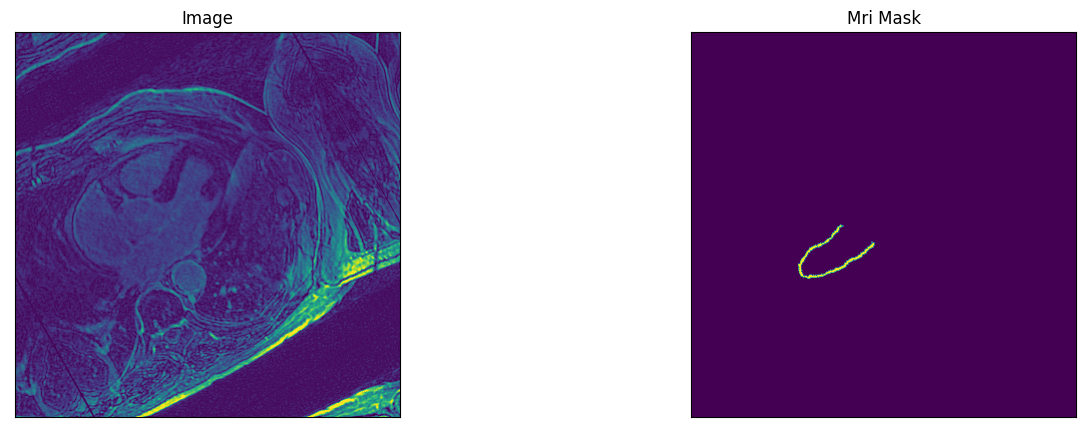

0.105882354 1.0 (1, 384, 384) <class 'numpy.ndarray'> 0.30373016
0.0 1.0 (1, 384, 384) <class 'numpy.ndarray'> 0.0030110676


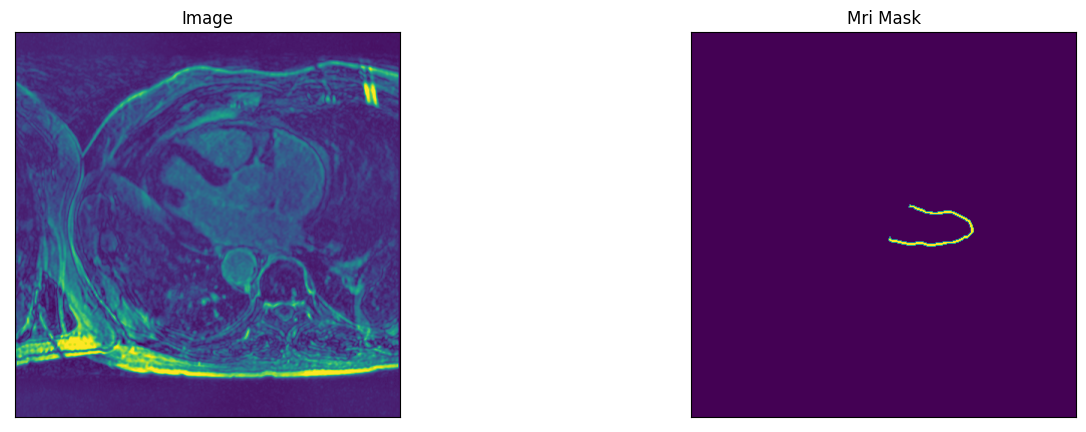

0.21176471 1.0 (1, 384, 384) <class 'numpy.ndarray'> 0.31075484
0.0 1.0 (1, 384, 384) <class 'numpy.ndarray'> 0.0030110676


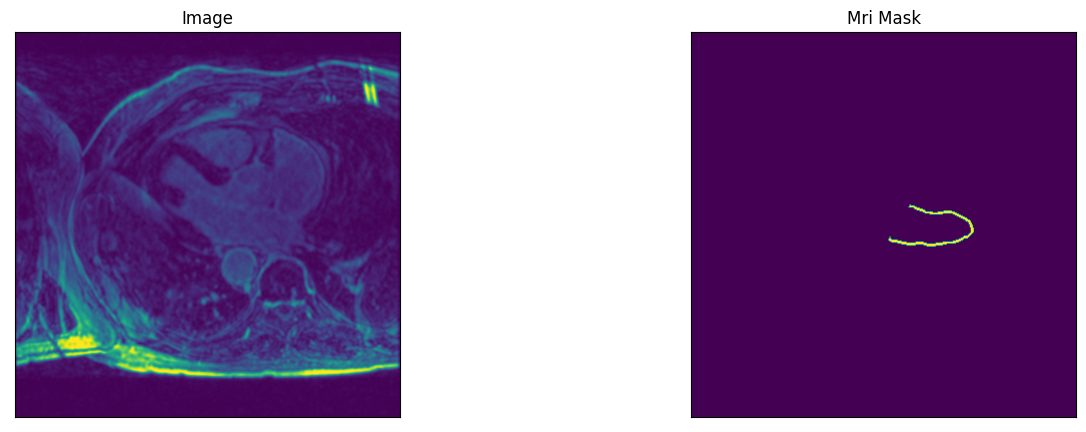

0.11764706 1.0 (1, 384, 384) <class 'numpy.ndarray'> 0.20973825
0.0 1.0 (1, 384, 384) <class 'numpy.ndarray'> 0.0030110676


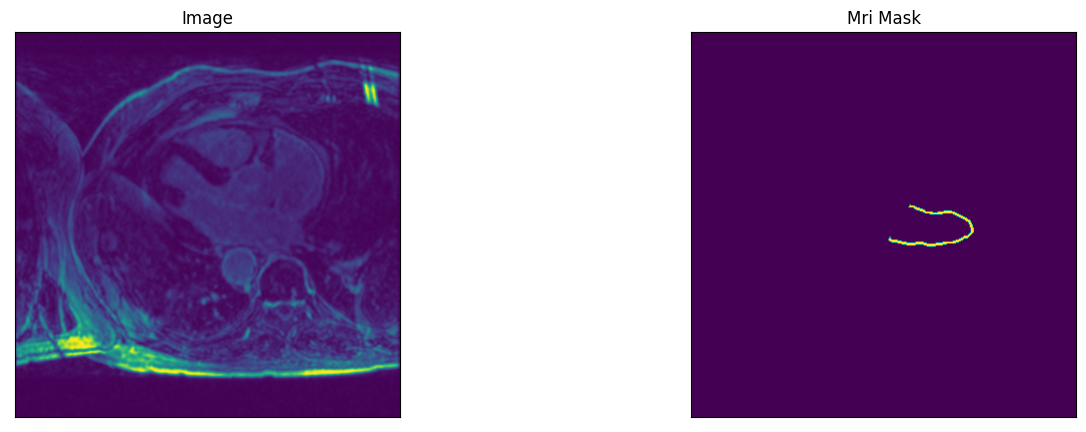

In [10]:
augmented_dataset = AtriaDataset(training_dir,
                                 augmentation=get_training_augmentation(),
                                 preprocessing=get_preprocessing())

for i in range(4):
    image, mask = augmented_dataset[131]
    print(np.min(image), np.max(image), image.shape, type(image), np.mean(image))
    print(np.min(mask), np.max(mask), mask.shape, type(mask), np.mean(mask))

    visualize(
    image=image, 
    mri_mask=mask,
)

In [11]:
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics as smp_metrics
import segmentation_models_pytorch.utils.losses as smp_losses

In [12]:
train_dataset = AtriaDataset(training_dir, augmentation=get_training_augmentation(), 
                             preprocessing=get_preprocessing())

valid_dataset = AtriaDataset(validation_dir, preprocessing=get_preprocessing())

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

In [14]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS,
    in_channels = 1,
    activation=ACTIVATION,
)

In [15]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [16]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [17]:
# train model for 40 epochs
max_score = 0
num_epochs = 100
each_epoch_train_dice_loss = []
each_epoch_valid_dice_loss = []
each_epoch_train_iou_score = []
each_epoch_valid_iou_score = []

for epoch in range(num_epochs):
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_unet_norm_dice_test.pth')
        print('Model saved!')
        
    #if epoch == 24:
        #optimizer.param_groups[0]['lr'] = 1e-5
        #print('Decrease decoder learning rate to 1e-5!')
    
    each_epoch_train_dice_loss.append(train_logs['dice_loss'])
    each_epoch_valid_dice_loss.append(valid_logs['dice_loss'])
    each_epoch_train_iou_score.append(train_logs['iou_score'])
    each_epoch_valid_iou_score.append(valid_logs['iou_score'])

Epoch 1/100
valid: 100%|█████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 47.23it/s, dice_loss - 0.7906, iou_score - 0.2522]
Model saved!
Epoch 2/100
valid: 100%|█████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 46.79it/s, dice_loss - 0.7858, iou_score - 0.3459]
Model saved!
Epoch 3/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 46.73it/s, dice_loss - 0.7198, iou_score - 0.393]
Model saved!
Epoch 4/100
valid: 100%|█████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 49.11it/s, dice_loss - 0.6862, iou_score - 0.4144]
Model saved!
Epoch 5/100
valid: 100%|█████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 49.84it/s, dice_loss - 0.6196, iou_score - 0.4097]
Epoch 6/100
valid: 100%|█████████████████████████████████████████████████████████████████████| 268/268 [00:0

valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 48.92it/s, dice_loss - 0.6929, iou_score - 0.306]
Epoch 27/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 49.56it/s, dice_loss - 0.6929, iou_score - 0.306]
Epoch 28/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 49.66it/s, dice_loss - 0.6929, iou_score - 0.306]
Epoch 29/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 47.68it/s, dice_loss - 0.6929, iou_score - 0.306]
Epoch 30/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 49.51it/s, dice_loss - 0.6929, iou_score - 0.306]
Epoch 31/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 49.58it/s, dice_loss - 0.6929, iou_score - 0.306]

valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 45.15it/s, dice_loss - 0.6929, iou_score - 0.306]
Epoch 52/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 48.99it/s, dice_loss - 0.6929, iou_score - 0.306]
Epoch 53/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 47.44it/s, dice_loss - 0.6929, iou_score - 0.306]
Epoch 54/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 47.08it/s, dice_loss - 0.6929, iou_score - 0.306]
Epoch 55/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 48.58it/s, dice_loss - 0.6929, iou_score - 0.306]
Epoch 56/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 48.25it/s, dice_loss - 0.6929, iou_score - 0.306]

valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 47.24it/s, dice_loss - 0.6929, iou_score - 0.306]
Epoch 77/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:11<00:00, 23.80it/s, dice_loss - 0.6929, iou_score - 0.306]
Epoch 78/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:11<00:00, 23.72it/s, dice_loss - 0.6929, iou_score - 0.306]
Epoch 79/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 49.19it/s, dice_loss - 0.6929, iou_score - 0.306]
Epoch 80/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 47.92it/s, dice_loss - 0.6929, iou_score - 0.306]
Epoch 81/100
valid: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [00:05<00:00, 49.22it/s, dice_loss - 0.6929, iou_score - 0.306]

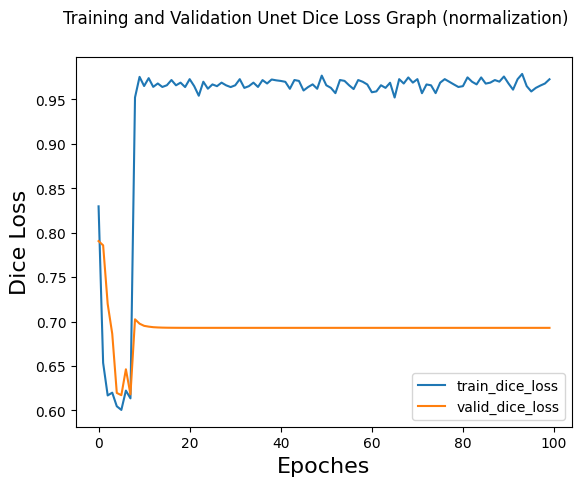

In [18]:
fig_loss = plt.figure()
fig_loss.suptitle("Training and Validation Unet Dice Loss Graph (normalization)")
plt.xlabel("Epoches", fontsize=16)
plt.ylabel("Dice Loss", fontsize=16)
plt.plot(each_epoch_train_dice_loss, label="train_dice_loss")
plt.plot(each_epoch_valid_dice_loss, label="valid_dice_loss")
plt.legend()
plt.show()
fig_loss.savefig("Training and Validation Unet Test Dice Loss Graph (normalization)3.png")

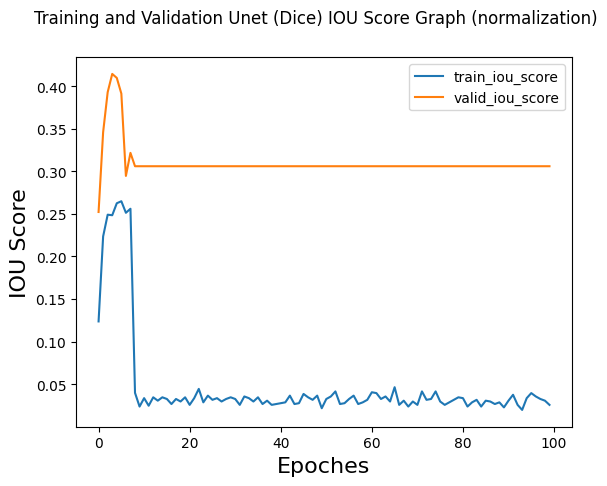

In [19]:
fig_iou = plt.figure()
fig_iou.suptitle("Training and Validation Unet (Dice) IOU Score Graph (normalization)")
plt.xlabel("Epoches", fontsize=16)
plt.ylabel("IOU Score", fontsize=16)
plt.plot(each_epoch_train_iou_score, label="train_iou_score")
plt.plot(each_epoch_valid_iou_score, label="valid_iou_score")
plt.legend()
plt.show()
fig_iou.savefig("Training and Validation Unet Test (Dice) IOU Score Graph (normalization)3.png")

In [20]:
best_model = torch.load('./best_model_unet_norm_dice_test.pth')

(384, 384, 1)
255


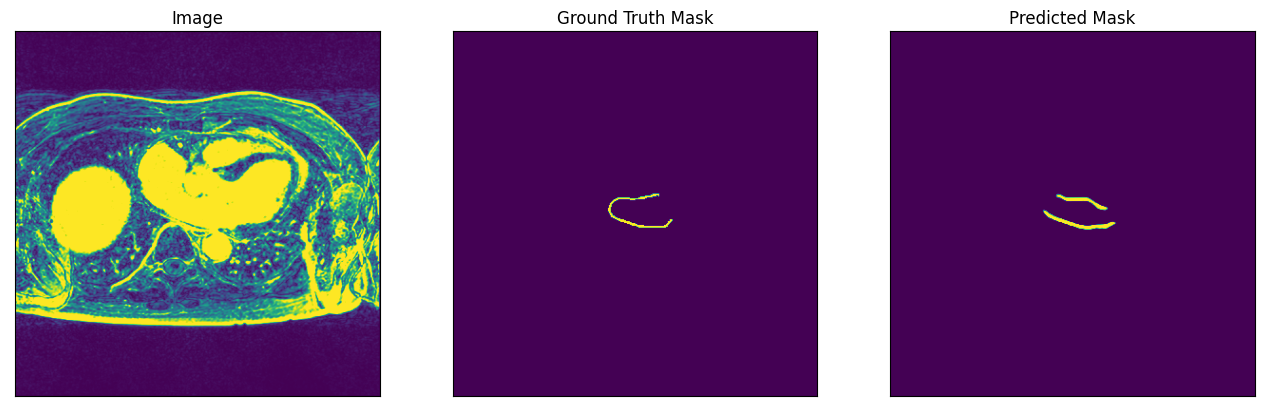

(384, 384, 1)
255


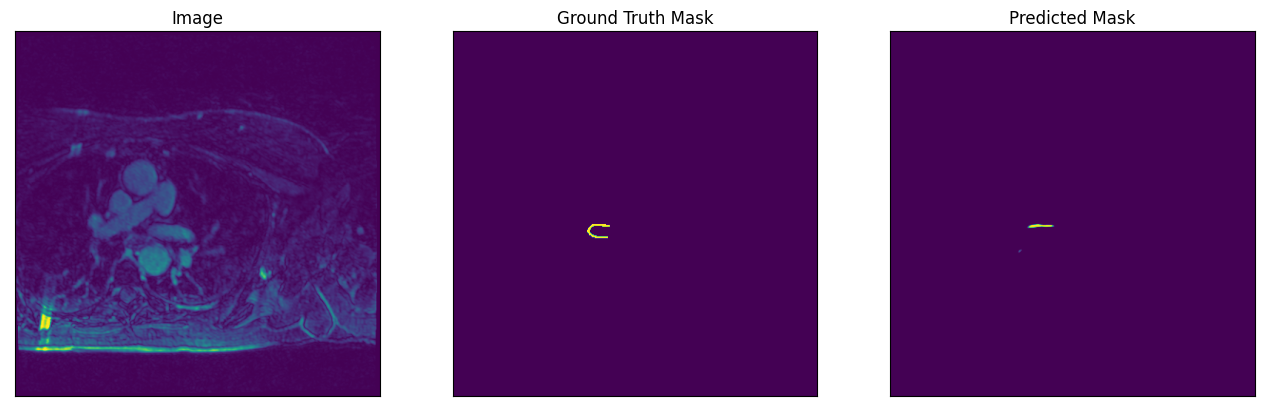

(384, 384, 1)
255


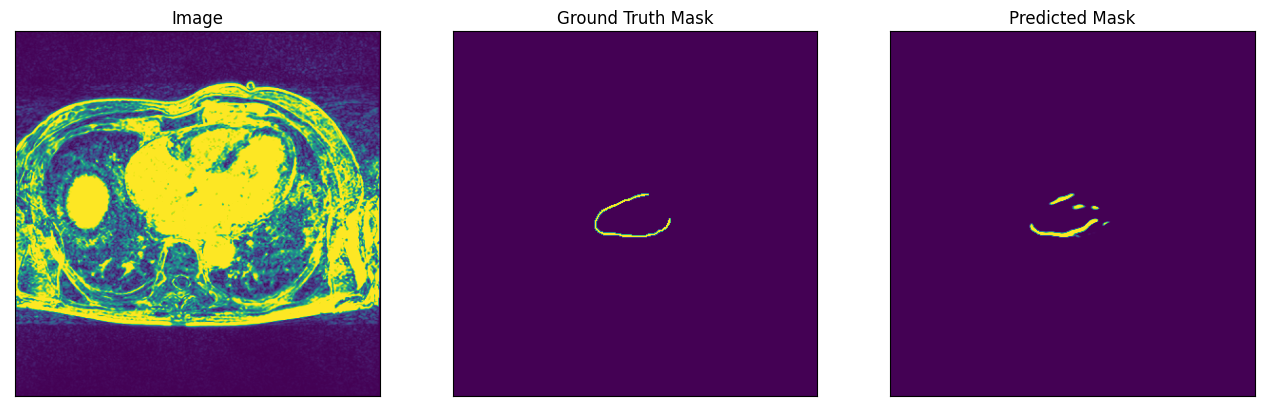

(384, 384, 1)
255


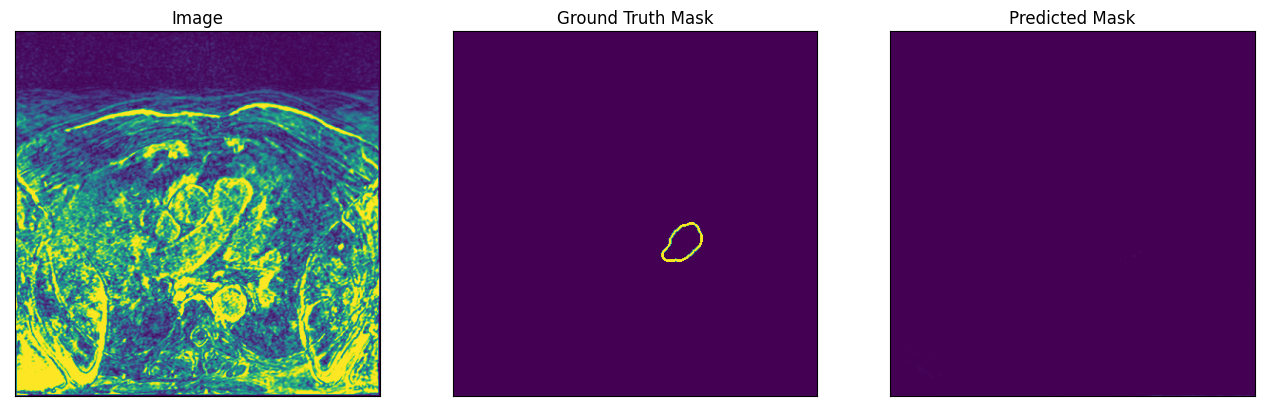

In [22]:
train_dataset = AtriaDataset(training_dir,
                            preprocessing=get_preprocessing())

train_show_dataset = AtriaDataset(training_dir)

for i in range(8):
    n = np.random.choice(len(train_dataset))
    #n = 131
    image_vis = train_show_dataset[n][0].astype('uint8')
    image, gt_mask = train_dataset[n]
    gt_mask = gt_mask.squeeze()
    
    count = (gt_mask == 1).sum()
    if count<10:
        continue
    print(image_vis.shape)
    print(np.max(image_vis))
    #image = image.transpose(2,0,1).astype("float32")
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    best_model = best_model.eval()
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy())
    pic_name = "prediction_wall_unet_dice_norm"+str(i)
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask,
        pic_name = pic_name
    )